In [1]:
import os
import time
import numpy as np
import pandas as pd 
from tqdm import tqdm
tqdm.pandas()
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# import training data 

In [2]:
train = pd.read_csv("../input/train.csv")

In [3]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


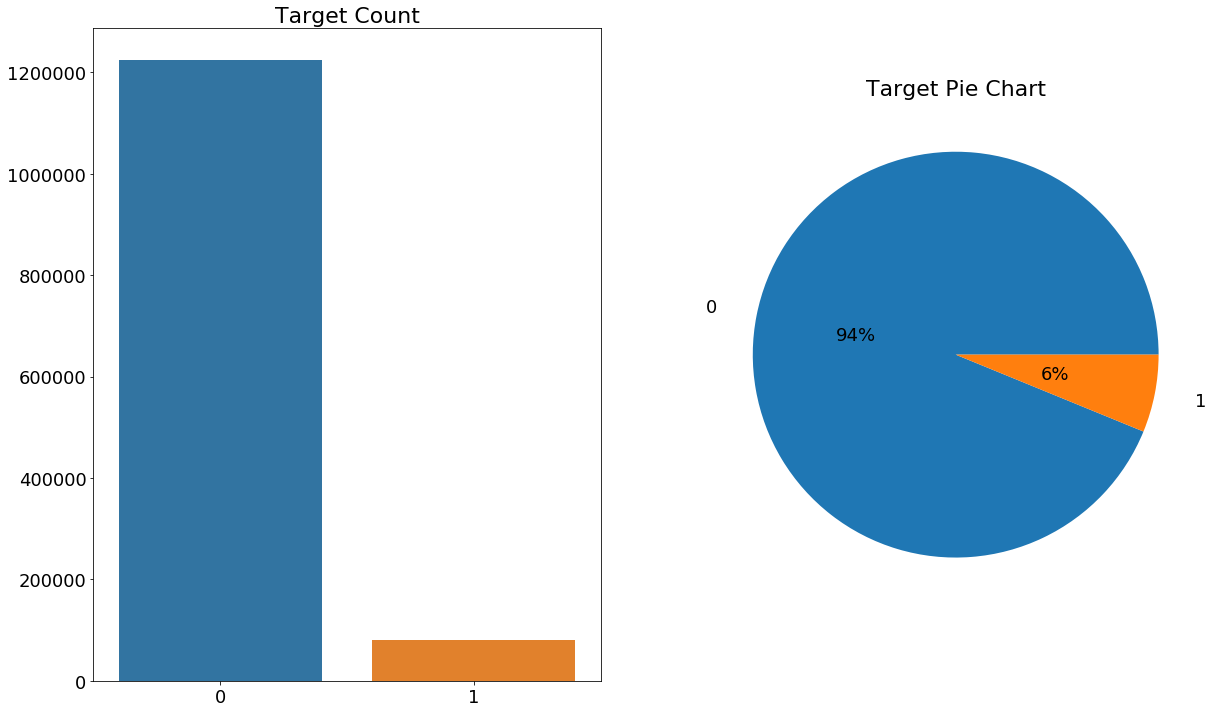

In [4]:
cnt_srs = train['target'].value_counts()

plt.rcParams['font.size'] = 18
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,12))
sns.barplot(cnt_srs.index, cnt_srs.values, ax = ax[0])
ax[0].set_title('Target Count', fontsize=22)

sizes = (np.array((cnt_srs / cnt_srs.sum())*100))
labels = (np.array(cnt_srs.index))

ax[1].pie(sizes, labels=labels, autopct='%1.0f%%', pctdistance=.5, labeldistance=1.2)
ax[1].set_title('Target Pie Chart', fontsize=22)

plt.show()
#fig.savefig('targetcount.png', dpi=300, bbox_inches='tight')

We have a very imbalanced class with 94% sincere questions and only 6% insincere questions. Thus, the F1 score is a great metric for model evaluation in this case. 

## Word cloud from the training dataset

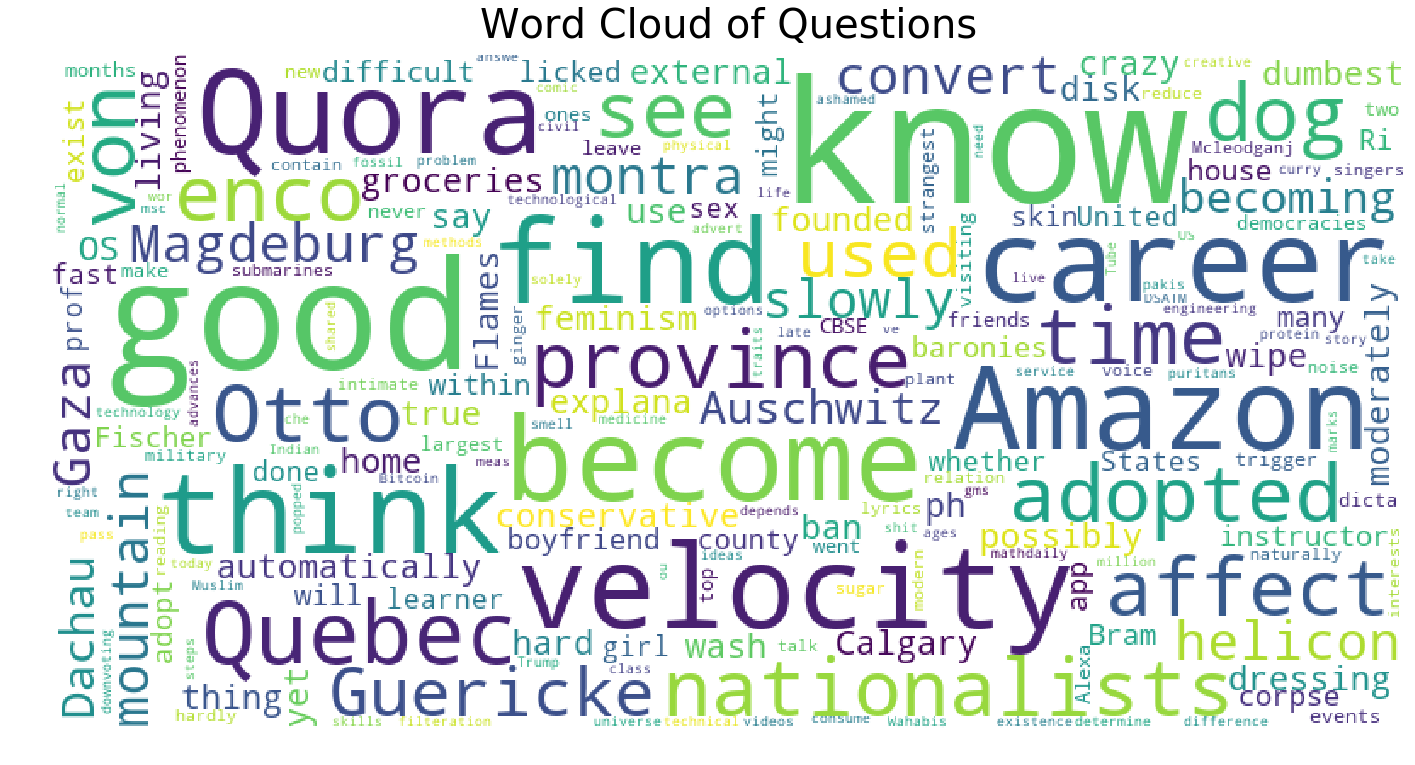

In [5]:
# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##

from wordcloud import WordCloud, STOPWORDS
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(20.0,14.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()
    #plt.savefig('quora_wordcloud.png', dpi=300)

# input for the function 
plot_wordcloud(train["question_text"], title="Word Cloud of Questions")

***

# text preprocessing and word embeddings

Let's dive in to the text cleaning process on the training dataset. In order to develop a matrix with correct embedding arrays, we need to clean up the training dataset to find the matching words in the embedding documents. 

## load in the embeddings files 

load in embeddings files and create a dictionary with key value pairs like   {'word': array([1.97, -0.63, ..., .573, 2.54])}


In [6]:
def load_word_embedding(filepath):
    """
    Given a filepath to embeddings file, return a word to vec dictionary, 
    in other words, word_embedding
    Ex. {'word': array([1.97, -0.63, ..., 0.573, 2.54])}
    """
    def _get_vec(word, *arr):
        return word, np.asarray(arr, dtype='float32')

    print('load word embedding ......')
    
    try:
        word_embedding = dict(_get_vec(*w.split(' ')) for w in open(filepath))
    except UnicodeDecodeError:
        word_embedding = dict(_get_vec(*w.split(' ')) for w in open(
            filepath, encoding="utf8", errors='ignore'))
    
    # sanity check for word vectors must with lengths of 300
    words_to_del = []
    for word, vec in word_embedding.items():
        if len(vec) != 300:
            words_to_del.append(word)
    for word in words_to_del:
        del word_embedding[word]
    return word_embedding



### GloVe

In [7]:
EMBEDDING_FILE_glove = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
embeddings_index_glove = load_word_embedding(EMBEDDING_FILE_glove)

load word embedding ......


### Paragram

In [8]:
EMBEDDING_FILE_para = '../input/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
embedding_index_para = load_word_embedding(EMBEDDING_FILE_para)

load word embedding ......


### Wiki

In [9]:
EMBEDDING_FILE_wiki = '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
embedding_index_wiki = load_word_embedding(EMBEDDING_FILE_wiki)

load word embedding ......


# build vocab and check coverage 

Thanks to an amazing Kaggler, we are able to go through our text, count the occurance of the contained words, and check how many vocabulary have matching embeddings array from the embedding documents.

https://www.kaggle.com/christofhenkel/how-to-preprocessing-when-using-embeddings


In [10]:
def build_vocab(sentences, verbose =  True):
    """
    input: list of list of words (sentences)
    output: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1             
            except KeyError:
                vocab[word] = 1
    return vocab

In [11]:
import operator 

def check_coverage(vocab,embeddings_index):
    """
    input: vocab dictionary and embedding index dictionary
    output: unmatched word/oov dictionary
    """
    a = {}
    oov = {}
    k = 0 #number of matched words
    i = 0 #number of unmatched words
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:
            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

In [12]:
sentences = train["question_text"].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)

100%|██████████| 1306122/1306122 [00:08<00:00, 162700.89it/s]


In [13]:
glove_oov = check_coverage(vocab, embeddings_index_glove)
glove_oov[:10]

100%|██████████| 508823/508823 [00:01<00:00, 414508.50it/s]

Found embeddings for 33.16% of vocab
Found embeddings for  88.16% of all text


[('India?', 16384),
 ('it?', 12900),
 ("What's", 12425),
 ('do?', 8753),
 ('life?', 7753),
 ('you?', 6295),
 ('me?', 6202),
 ('them?', 6140),
 ('time?', 5716),
 ('world?', 5386)]

In [14]:
para_oov = check_coverage(vocab, embedding_index_para)
para_oov[:10]

100%|██████████| 508823/508823 [00:01<00:00, 435940.20it/s]

Found embeddings for 19.59% of vocab
Found embeddings for  72.21% of all text


[('What', 417802),
 ('I', 306261),
 ('How', 261930),
 ('Why', 142291),
 ('Is', 108887),
 ('Can', 52698),
 ('Which', 47303),
 ('Do', 40041),
 ('If', 34557),
 ('Are', 29201)]

In [15]:
wiki_oov = check_coverage(vocab, embedding_index_wiki)
wiki_oov[:10]

100%|██████████| 508823/508823 [00:01<00:00, 439842.29it/s]


Found embeddings for 30.05% of vocab
Found embeddings for  87.66% of all text


[('India?', 16384),
 ("don't", 14991),
 ('it?', 12900),
 ("I'm", 12811),
 ("What's", 12425),
 ('do?', 8753),
 ('life?', 7753),
 ("can't", 7077),
 ('you?', 6295),
 ('me?', 6202)]

Looks like we are unable to match the vocabs that have puntuactuations attached to them. Hence, let's separate the vocab from the punctuations.

We also see that paragram embeddings doesn't support uppercase vocabs, so we need to change them all to lowercases

### Separate the punctuations

In [16]:
import string
regular_punct = list(string.punctuation)
extra_punct = [
        ',', '.', '"', ':', ')', '(', '!', '?', '|', ';', "'", '$', '&',
        '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
        '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',
        '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”',
        '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾',
        '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼',
        '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
        'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»',
        '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø',
        '¹', '≤', '‡', '√', '«', '»', '´', 'º', '¾', '¡', '§', '£', '₤']

all_punct = list(set(regular_punct + extra_punct))

def spacing_punctuation(text):
    """
    add space before and after punctuation and symbols
    """
    for punc in all_punct:
        if punc in text:            
            text = text.replace(punc, f" {punc} ")
            
    return text

In [17]:
train["question_text"] = train["question_text"].progress_apply(lambda x: spacing_punctuation(x))
sentences = train["question_text"].progress_apply(lambda x: x.split())
para_sentences = train["question_text"].progress_apply(lambda x: x.lower().split())

vocab = build_vocab(sentences)
para_vocab = build_vocab(para_sentences)

100%|██████████| 1306122/1306122 [00:07<00:00, 170436.75it/s]


In [18]:
glove_oov = check_coverage(vocab, embeddings_index_glove)
glove_oov[:10]

100%|██████████| 238917/238917 [00:00<00:00, 415355.37it/s]


Found embeddings for 75.02% of vocab
Found embeddings for  99.59% of all text


[('Quorans', 856),
 ('Brexit', 493),
 ('cryptocurrencies', 481),
 ('Redmi', 379),
 ('OnePlus', 125),
 ('UCEED', 123),
 ('Blockchain', 112),
 ('GDPR', 107),
 ('demonetisation', 106),
 ('Coinbase', 105)]

In [19]:
para_oov = check_coverage(para_vocab, embedding_index_para)
para_oov[:10]

100%|██████████| 195928/195928 [00:00<00:00, 406345.82it/s]


Found embeddings for 74.30% of vocab
Found embeddings for  99.64% of all text


[('quorans', 858),
 ('brexit', 524),
 ('cryptocurrencies', 499),
 ('redmi', 383),
 ('coinbase', 149),
 ('oneplus', 139),
 ('uceed', 123),
 ('demonetisation', 115),
 ('bhakts', 115),
 ('upwork', 111)]

In [20]:
wiki_oov = check_coverage(vocab, embedding_index_wiki)
wiki_oov[:10]

100%|██████████| 238917/238917 [00:00<00:00, 426374.87it/s]


Found embeddings for 67.38% of vocab
Found embeddings for  99.43% of all text


[('_', 1388),
 ('Quorans', 856),
 ('BITSAT', 562),
 ('COMEDK', 352),
 ('KVPY', 349),
 ('Quoran', 310),
 ('WBJEE', 231),
 ('mtech', 219),
 ('articleship', 191),
 ('VITEEE', 183)]

We are able to improve our total text coverage from 88% to 99% from just fixing the punctuations! Now let's do some cleaning on the misspelled words

## misspelled words

In [21]:
import re
def clean_misspell(text):
    """
    misspell list (quora vs. glove)
    """
    
    misspell_to_sub = {'demonitisation': 'demonetization', 'demonitization': 'demonetization', 
                    'demonetisation': 'demonetization',
                    'pokémon': 'pokemon',
                    'Wjy': 'Why',
                    'Whst' : 'What',
                    'BNBR': 'Be Nice Be Respectful',
                    'Bolsonaro': 'Jair Bolsonaro',
                    'XXXTentacion': 'Tentacion',
                    'Žižek': 'Slovenian philosopher Slavoj Žižek',
                    'Adityanath': 'Indian monk Yogi Adityanath',
                    'Brexit': 'British Exit',
                    'Brexiter': 'British Exit supporter',
                    'Brexiters': 'British Exit supporters',
                    'Brexiteer': 'British Exit supporter',
                    'Brexiteers': 'British Exit supporters',
                    'Brexiting': 'British Exit',
                    'Brexitosis': 'British Exit disorder',
                    'brexit': 'British Exit',
                    'brexiters': 'British Exit supporters',
                    'cryptocurrencies': 'cryptocurrency',
                    'Cryptocurrency': 'cryptocurrency',
                    'Litecoin' : 'cryptocurrency',
                    'litecoin' : 'cryptocurrency',
                    'altcoin' : 'cryptocurrency',
                    'altcoins' : 'cryptocurrency',
                    'jallikattu': 'Jallikattu',
                    'Swachh': 'Swachh Bharat mission campaign',
                    'SJWs': 'social justice warrior',
                    'Quorans': 'Quoran',
                    'Qoura': 'Quora',
                    'quoras': 'Quora',
                    'Quroa': 'Quora',
                    'QUORA': 'Quora',
                    'Qoura': 'Quora',
                    'narcissit': 'narcissist',
                    'ethereum': 'Ethereum',
                    'Blockchain': 'blockchain',
                    'UCEED': 'Undergraduate Common Entrance Examination for Design',
                    'GDPR': 'General Data Protection Regulation',
                    'Redmi' : 'Xiaomi smartphone',
                    'OnePlus': 'Android smartphone',
                    'Machedo' : 'hot guy',
                    'Coinbase':'bitcoin broker',
                    'coinbase':'bitcoin broker',
                    'DCEU' : 'American media franchise',
                    'IIEST': 'Indian Institutes of Engineering Science and Technology',
                    'Upwork' : 'global freelancing platform',
                    'upwork' : 'global freelancing platform',
                    'HackerRank' : 'technology company focuses on competitive programming challenges',
                    'pokémon': 'pokemon'}

    misspell_re = re.compile('(%s)' % '|'.join(misspell_to_sub.keys()))

    def _replace(match):
        """
        reference: https://www.kaggle.com/hengzheng/attention-capsule-why-not-both-lb-0-694 # noqa
        """
        try:
            word = misspell_to_sub.get(match.group(0))
        except KeyError:
            word = match.group(0)
            print('!!Error: Could Not Find Key: {}'.format(word))
        return word
    return misspell_re.sub(_replace, text)

In [22]:
train["question_text"] = train["question_text"].progress_apply(lambda x: clean_misspell(x))
sentences = train["question_text"].progress_apply(lambda x: x.split())
para_sentences = train["question_text"].progress_apply(lambda x: x.lower().split())

vocab = build_vocab(sentences)
para_vocab = build_vocab(para_sentences)

100%|██████████| 1306122/1306122 [00:07<00:00, 170276.61it/s]


In [23]:
glove_oov = check_coverage(vocab, embeddings_index_glove)
glove_oov[:10]

100%|██████████| 238872/238872 [00:00<00:00, 389855.97it/s]

Found embeddings for 75.04% of vocab
Found embeddings for  99.61% of all text


[('Adityanath', 99),
 ('Boruto', 93),
 ('LNMIIT', 67),
 ('Zerodha', 65),
 ('Kavalireddi', 65),
 ('bhakts', 63),
 ('Doklam', 62),
 ('NICMAR', 59),
 ('Vajiram', 59),
 ('Unacademy', 58)]

In [24]:
para_oov = check_coverage(para_vocab, embedding_index_para)
para_oov[:10]

100%|██████████| 195919/195919 [00:00<00:00, 405907.67it/s]


Found embeddings for 74.30% of vocab
Found embeddings for  99.66% of all text


[('bhakts', 115),
 ('adityanath', 106),
 ('boruto', 102),
 ('alshamsi', 92),
 ('unacademy', 86),
 ('zerodha', 80),
 ('tensorflow', 74),
 ('doklam', 70),
 ('kavalireddi', 69),
 ('lnmiit', 68)]

In [25]:
wiki_oov = check_coverage(vocab, embedding_index_wiki)
wiki_oov[:10]

100%|██████████| 238872/238872 [00:00<00:00, 422034.46it/s]

Found embeddings for 67.38% of vocab
Found embeddings for  99.43% of all text


[('_', 1388),
 ('Quoran', 1166),
 ('BITSAT', 562),
 ('COMEDK', 352),
 ('KVPY', 349),
 ('WBJEE', 231),
 ('mtech', 219),
 ('articleship', 191),
 ('VITEEE', 183),
 ('UPES', 153)]

Out of the three embedding files, we can also see that glove embedding have covered the most percentage of vocabs.

From the above observation, we can see some of the characteristics from the three embedding documents:



    GloVe:
        1. supports uppper case words
        2. supports digit
        3. supports punctuation
        5. supports domains e.g. www.apple.com
        6. supports misspelled words e.g. FUCKKK
        
    Paragram:
        1. does NOT support uppper case words
            (all lower case)
        2. supports digit
        3. supports punctuation and special punctuation
        4. supports domains e.g. www.apple.com
        5. supports misspelled word e.g. travelling, organisation

    
    Wiki:
        1. supports uppper case words
        2. supports digit
        3. supports ONLY some punctuation
        4. does NOT supports domains e.g. www.apple.com
        5. does NOT supports misspelled word e.g. travelling, organisation
            (unclear it supports misspelled words)
